<a href="https://colab.research.google.com/github/PaixaoThales/weather_report_M_L/blob/main/weather_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise do Impacto de Furacões no Turismo e Previsão de Receitas Durante Eventos Extremos

## Bloco 1: Configuração do ambiente

In [ ]:
!pip install pandas numpy matplotlib scikit-learn tensorflow

## Bloco 2: Importação de bibliotecas
### Bibliotecas Usadas
- pandas: Usada para manipulação e análise de dados. Aqui, é usada para carregar, processar e mesclar os datasets.
- numpy: Biblioteca para cálculos matemáticos e manipulação de arrays. Usada para preparar sequências e calcular métricas.
- matplotlib.pyplot: Biblioteca de visualização para gráficos simples. Usada para exibir gráficos dos resultados e análise.
- matplotlib.dates: Ferramentas para trabalhar com datas em gráficos.
- sklearn.preprocessing.MinMaxScaler: Ferramenta para normalizar dados, transformando-os para um intervalo fixo (geralmente 0 a 1).
- tensorflow.keras: Biblioteca para redes neurais. Aqui, usada para criar e treinar um modelo LSTM (Long Short-Term Memory) para prever séries temporais.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Bloco 3: Carregar datasets

Este bloco carrega os arquivos CSV com os dados:

- tax-sales-hurricane.csv: Dados de receitas relacionadas ao turismo, possivelmente impactadas por furacões.
- Employment.csv: Dados de emprego por estado.
- covid-19.csv: Dados de novos casos diários de COVID-19 por estado.
As colunas de datas são automaticamente convertidas para o tipo datetime, facilitando a manipulação temporal.


In [ ]:
tourism_data = pd.read_csv("tax-sales-hurricane.csv", parse_dates=["Date"])
employment_data = pd.read_csv("Employment.csv", parse_dates=["Date"])
covid_data = pd.read_csv("covid-19.csv", parse_dates=["Date"])

print("Dados carregados com sucesso!")

Dados carregados com sucesso!


## Bloco 4: Função para pré-processar os dados

Este bloco define uma função para pré-processar os dados e remove valores ausentes (NaN). Apenas colunas relevantes são mantidas nos datasets:

- tourism_data: Colunas Date, region, observed (receita) e hurricane.
- covid_data: Colunas Date, stateAbbr (abreviação do estado) e dailynewcases (novos casos diários).
- employment_data: Colunas Date, stateFull (nome do estado completo) e Employees.


In [ ]:
def preprocess_data(df, key_columns):
    """Filtrar colunas chave e remover valores ausentes."""
    df = df[key_columns].dropna()
    return df

# Aplicar a função nos datasets
tourism_data = preprocess_data(
    tourism_data, ["Date", "region", "observed", "hurricane"]
)
covid_data = preprocess_data(covid_data, ["Date", "stateAbbr", "dailynewcases"])
employment_data = preprocess_data(employment_data, ["Date", "stateFull", "Employees"])

## Bloco 5: Combinar datasets

Os datasets são unificados com base na coluna Date. A unificação usa how="left", o que significa que todos os dados de tourism_data são mantidos e, onde houver correspondência, dados de covid_data e employment_data são adicionados.

In [ ]:
merged_data = tourism_data.merge(
    covid_data, left_on="Date", right_on="Date", how="left"
)
merged_data = merged_data.merge(
    employment_data, left_on="Date", right_on="Date", how="left"
)

print("Tamanho dos dados combinados:", merged_data.shape)
merged_data.head()

Tamanho dos dados combinados: (9936, 8)


,Date,region,observed,hurricane,stateAbbr,dailynewcases,stateFull,Employees
0,2002-01-01,Alachua,0.800634,0,NaN,NaN,NaN,NaN
1,2002-02-01,Alachua,0.566527,0,NaN,NaN,NaN,NaN
2,2002-03-01,Alachua,0.635659,0,NaN,NaN,NaN,NaN
3,2002-04-01,Alachua,0.734314,0,NaN,NaN,NaN,NaN
4,2002-05-01,Alachua,0.575498,0,NaN,NaN,NaN,NaN


## Bloco 6: Normalizar dados com MinMaxScaler

Os valores da coluna observed são normalizados para o intervalo [0, 1] usando MinMaxScaler. Isso é necessário porque redes neurais geralmente funcionam melhor com dados normalizados.

In [ ]:
scaler = MinMaxScaler()
merged_data["observed_scaled"] = scaler.fit_transform(merged_data[["observed"]])

merged_data[["Date", "observed", "observed_scaled"]].head()

,Date,observed,observed_scaled
0,2002-01-01,0.800634,0.082765
1,2002-02-01,0.566527,0.055547
2,2002-03-01,0.635659,0.063584
3,2002-04-01,0.734314,0.075054
4,2002-05-01,0.575498,0.056590


## Bloco 7: Função para preparar sequências (modelagem)

Aqui são criadas sequências para a rede neural LSTM. A função divide os dados em:
- X: Entradas (sequências de 12 meses).
- y: Saídas (valor do próximo mês).
Isso é necessário porque o LSTM modela relações temporais.


In [ ]:
def prepare_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 12  # Dados mensais, janela de 1 ano
observed_values = merged_data["observed_scaled"].values
X, y = prepare_sequences(observed_values, sequence_length)

## Bloco 8: Divisão em Treino e Teste

Os dados são divididos em conjuntos de treino (80%) e teste (20%). Além disso, os dados são remodelados para o formato esperado pela LSTM, que precisa de 3 dimensões (amostras, sequência, features).

In [ ]:
split_idx = int(len(X) * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

# Reformatar para LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Bloco 9: Criar o modelo

O modelo LSTM é criado com as seguintes camadas:

- LSTM: 50 neurônios, com ativação ReLU, processando sequências.
- Dropout: Regularização para evitar overfitting.
- Dense: Camada densa para gerar a previsão final.
O modelo usa adam como otimizador e mse (erro médio quadrático) como função de perda.

In [ ]:
model = Sequential(
    [
        LSTM(50, activation="relu", input_shape=(sequence_length, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation="relu"),
        Dropout(0.2),
        Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mse")
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 12, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

## Bloco 10: Treinar o modelo

O modelo é treinado por 20 épocas com lotes de 32 amostras. O conjunto de validação é usado para monitorar o desempenho.

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 9.3200e-04 - val_loss: 0.0015
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━

## Bloco 11: Fazer previsões

As previsões são feitas no conjunto de teste, e os valores normalizados são revertidos para o formato original.

O MSE é usado como uma métrica objetiva para entender o quão bem o modelo foi capaz de prever os dados. Quanto menor o MSE, melhor o modelo.

In [ ]:
predictions = model.predict(X_test)

# Reverter a normalização
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions = scaler.inverse_transform(predictions)

mse = np.mean((y_test - predictions) ** 2)
print(f"Mean Squared Error: {mse:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Mean Squared Error: 0.12


# Bloco 12.1: Gráfico comparativo

Um gráfico é gerado para comparar os valores reais e previstos.


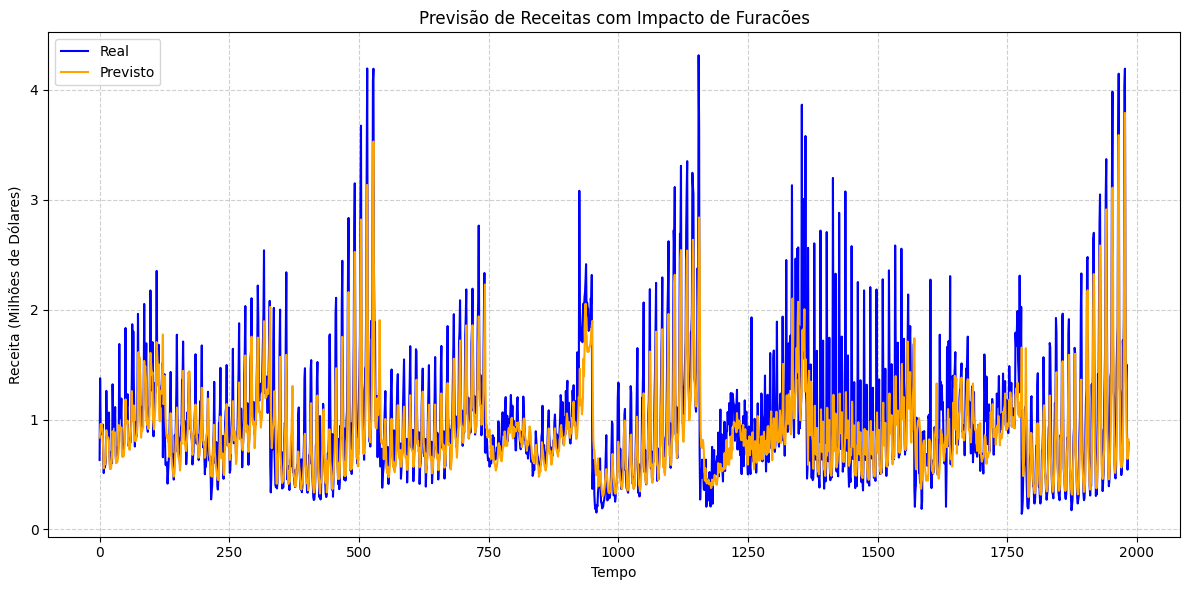

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label="Real", color="blue")
plt.plot(range(len(predictions)), predictions, label="Previsto", color="orange")
plt.title("Previsão de Receitas com Impacto de Furacões")
plt.xlabel("Tempo")
plt.ylabel("Receita (Milhões de Dólares)")
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Bloco 12.2: Gráfico comparativo (zoom)

Um gráfico é gerado para comparar os valores reais e previstos com zoom temporal.


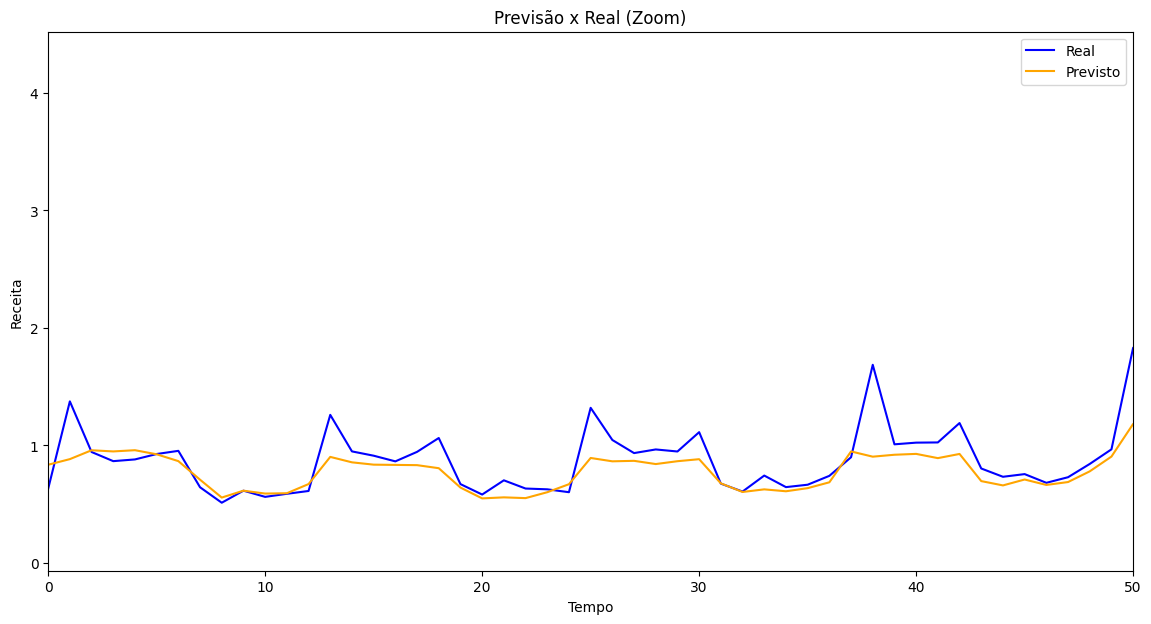

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_test)), y_test, label="Real", color="blue")
plt.plot(range(len(predictions)), predictions, label="Previsto", color="orange")
plt.title("Previsão x Real (Zoom)")
plt.xlabel("Tempo")
plt.ylabel("Receita")
plt.legend()
plt.xlim(0, 50)  # Ajustar para zoom no período inicial de teste
plt.show()

## Bloco 13: Detectar outliers

Outliers (valores muito altos ou baixos) são detectados usando os quantis 5% e 95%. Esses pontos são destacados em um gráfico.

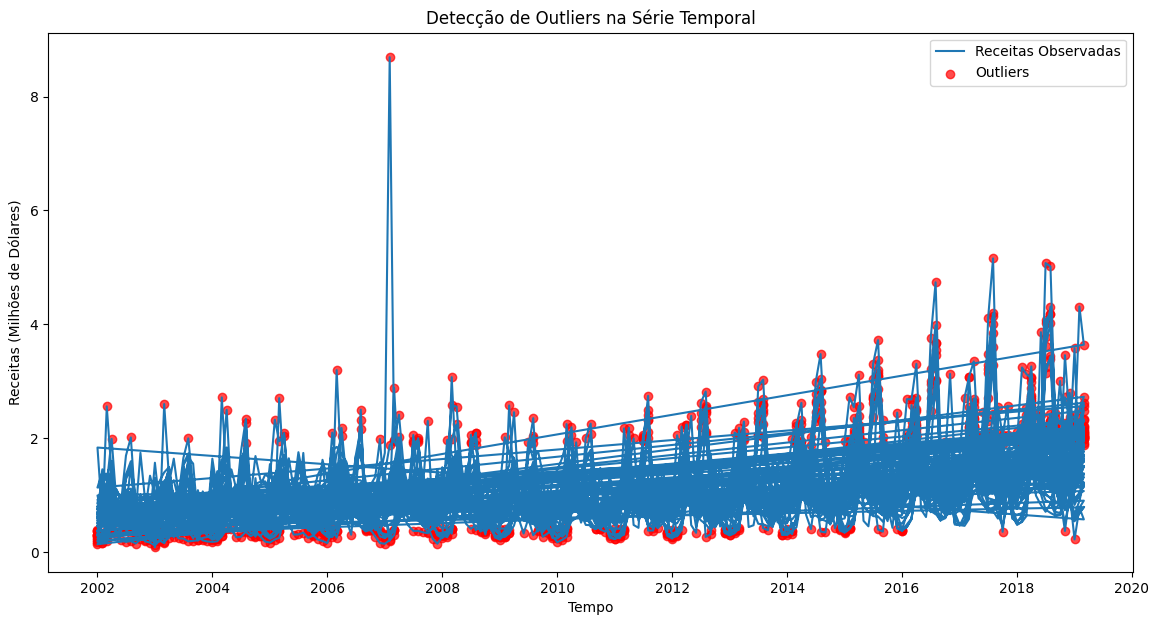

In [ ]:
outliers = merged_data[
    (merged_data["observed"] > merged_data["observed"].quantile(0.95))
    | (merged_data["observed"] < merged_data["observed"].quantile(0.05))
]
plt.figure(figsize=(14, 7))
plt.plot(merged_data["Date"], merged_data["observed"], label="Receitas Observadas")
plt.scatter(
    outliers["Date"],
    outliers["observed"],
    color="red",
    label="Outliers",
    alpha=0.7,
)
plt.title("Detecção de Outliers na Série Temporal")
plt.xlabel("Tempo")
plt.ylabel("Receitas (Milhões de Dólares)")
plt.legend()
plt.show()
